Pulse programming on OQC Lucy in PennyLane
==========================================

*Author: Korbinian Kottmann. Posted: 30 October 2023.*

Pulse-level access to quantum computers offers many interesting new
avenues in quantum optimal control, variational quantum algorithms and
device-aware algorithm design. We now have the possibility to run
hardware-level circuits combined with standard gates on a physical
device in `PennyLane` via `AWS Braket` on OQC\'s Lucy quantum computer.
In this demo, we explain the underlying physical principles of driving
transmon qubits and show how to perform custom pulse gates on hardware
through PennyLane.

<img src="https://pennylane.ai/_images/thumbnail_intro_oqc_pulse.png" width=500 />

Introduction
------------

Additionally to accessing [neutral atom quantum computers by Quera
through PennyLane and AWS](ahs_aquila), we now have the possibility to
access Lucy by Oxford Quantum Computing (OQC), an 8-qubit
superconducting quantum computer with a ring-like connectivity. Through
the [PennyLane-Braket
plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/),
we are able to design custom pulse gates that control the physical
qubits at the lowest hardware level. A neat feature is the ability to
combine *digital* gates like $\text{CNOT}, H, R_x, R_y, R_z$
with *pulse* gates. This ability allows us to differentiate
parametrized pulse gates natively on hardware via our recently
introduced *ODEgen* method, which we will discuss in detail
in a future demo.

In this demo, we are going to explore the physical principles for
hardware level control of transmon qubits and run custom pulse gates on
OQC Lucy via the [pennylane-braket
plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/).
For a general introduction to pulse programming, see our [recent demo on
it](tutorial_pulse_programming101).

Note:

To access remote services on Amazon Braket, you first need to [create an
account on AWS](https://aws.amazon.com/braket/getting-started/) and
follow the [setup
instructions](https://github.com/aws/amazon-braket-sdk-python) for
accessing Braket from Python. You also need to install the
[pennylane-braket
plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/).


Transmon Physics
----------------

In this section, we are going to give an intuitive intro to the physical
principles behind the control of superconducting transmon qubits.

Oxford Quantum Circuit\'s Lucy is a quantum computer with 8
superconducting transmon qubits based on the Coaxmon design [1]. In order to
control a transmon qubit, it is driven by a microwave pulse. The
interaction between the transmon and the pulse can be modeled by the
Hamiltonian

$$H(t) = - \frac{\omega_q}{2} Z_q + \Omega_q(t) \sin(\nu_q t + \phi_q) Y_q$$

where operators $\{X_q, Y_q, Z_q\}$ refer to the single-qubit Pauli
operators acting on qubit $q$, $\omega_q$ is the qubit frequency,
$\Omega_q(t)$ is the drive amplitude, $\nu_q$ denotes the drive
frequency, and $\phi_q$ is the phase of the pulse. All of these
parameters are given or set for each qubit $q =0, 1, .., 7$ on the
device. Since we are going to focus on driving one single qubit, we are
going to drop the subscript $q$ from here on. We refer to section IV D
in reference [2] for a good derivation and review from first principles.

We now want to understand the action of driving a qubit with this
Hamiltonian. The first term leads to a constant precession around the
Z-axis on the Bloch sphere, whereas the second term introduces the
so-called Rabi oscillation between $|0\rangle$ and $|1\rangle$. This can
be seen by the following simple simulation: We evolve the state in the
Bloch sphere from $|0\rangle$ with a constant pulse of
$\Omega(t) = 2 \pi \text{ GHz}$ for $1 \text{ ns}$. We choose
$\omega = 5 \times 2\pi \text{ GHz}$ as the drive and qubit frequency
(i.e. we are at resonance $\omega - \nu = 0$).


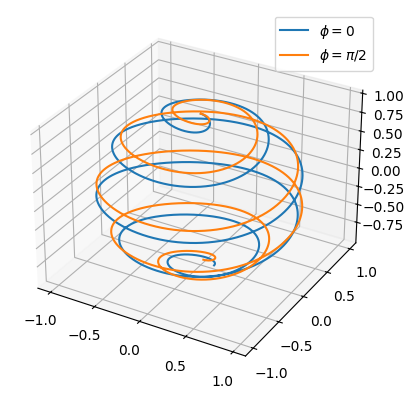

In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from datetime import datetime

X, Y, Z = qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)

omega = 2 * jnp.pi * 5.

# To generate a time-dependent ``ParametrizedHamiltonian``, we multiply a ``callable``
# and an ``Operator``.
# Due to PennyLane convention, the callable has to have the signature (p, t).
# Here, the only parameter that we control is the phase ``p`` in the sinusodial.
def amp(nu):
    def wrapped(p, t):
        return jnp.pi * jnp.sin(nu*t + p)
    return wrapped

H = -omega/2 * qml.PauliZ(0)
H += amp(omega) * qml.PauliY(0)

# We generate a qnode that evolves the qubit state according to the time-dependent 
# Hamiltonian H.
@jax.jit
@qml.qnode(qml.device("default.qubit", wires=1), interface="jax")
def trajectory(params, t):
    qml.evolve(H)((params,), t, return_intermediate=True)
    return [qml.expval(op) for op in [X, Y, Z]]

# By setting ``return_intermediate=True``, we can output all intermediate time steps.
# We compute the time series for 10000 samples for the phase equal to 0 and pi/2, respectively.
ts = jnp.linspace(0., 1., 10000)
res0 = trajectory(0., ts)
res1 = trajectory(jnp.pi/2, ts)

# We plot the evolution in the Bloch sphere.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(*res0, "-", label="$\\phi=0$")
ax.plot(*res1, "-", label="$\\phi=\\pi/2$")
ax.legend()

Image: Driving a transmon qubits leads to a spiral movement on the Bloch
sphere in the lab frame. It results from a constant Z-axis precession
together with the Rabi oscillation from the drive on
resonance.

We can see that for a fixed time, we land on different longitudes on the
Bloch sphere for different phases $\phi$. This means that we can control
the rotation axis of the logical gate by setting the phase $\phi$ of the
drive. Another way of seeing this is by fixing the pulse duration and
looking at the final state for different amplitudes and two phases
shifted by $\pi/2$.


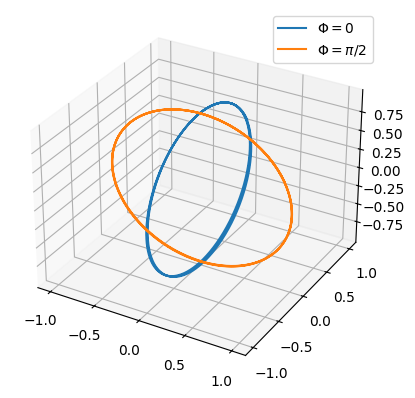

In [2]:
# We change the ``callable`` of the time-dependent Hamiltonian and 
# now can control both amplitude (p[0]) and phase (p[1]).
def amp(nu):
    def wrapped(p, t):
        return p[0] * jnp.sin(nu*t + p[1])
    return wrapped

H1 = -omega/2 * qml.PauliZ(0)
H1 += amp(omega) * Y

# This time we compute the full evolution until the final time after 20ns
# return_intermediate=False is the default, so we dont have to set it explicitly.
@jax.jit
@qml.qnode(qml.device("default.qubit", wires=1), interface="jax")
def trajectory(Omega0, phi):
    qml.evolve(H1)([[Omega0, phi]], 20.)
    return [qml.expval(op) for op in [X, Y, Z]]

# We use ``jax.vmap`` to efficiently evaluate the ``trajectory`` function for all amplitudes 
# ``Omegas``. We repeat that procedure for the phase equal to 0 and pi/2 again.
Omegas = jnp.linspace(0., 1., 10000)
res0 = jax.vmap(trajectory, [0, None])(Omegas, 0.)
res1 = jax.vmap(trajectory, [0, None])(Omegas, jnp.pi/2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(*res0, "-", label="$\\Phi=0$")
ax.plot(*res1, "-", label="$\\Phi=\\pi/2$")
ax.legend()

Image: Results on the Bloch sphere after driving with different amplitudes
and phases. Setting the phase $\phi$ leads to different rotation
axes.

So far, we have looked at transmon physics in the so-called lab frame.
Another common way of understanding transmon physics is via the
Hamiltonian expressed in the *qubit frame,* which rotates at
the qubit frequency. We can change frames via the unitary transformation
$R = e^{-i \frac{\omega}{2}Z}$ that leads to the transformed Hamiltonian
$\tilde{H}(t) = i R R^\dagger + R H R^\dagger$. In the rotating wave
approximation (RWA) and on resonance ($\omega = \nu$), this yields

$$\tilde{H}(t) = - \frac{1}{2} \Omega(t) (\cos(\phi) X + \sin(\phi) Y).$$

This is another way of seeing how setting the phase $\phi$ controls the
rotation axis of the qubit. In particular, we see how $\phi = 0$
($\pi/2$) leads to a $X$ ($Y$) rotation. For a detailed derivation of
the qubit frame Hamiltonian above, see reference [2], section IV, D1 (eq.
(79) onwards).

Rabi Oscillation Calibration
============================

We now want to drive a qubit on OQC\'s Lucy by sending custom pulses via
PennyLane. For better comparability with classical simulations, we
calibrate the attenuation $\xi$ between the device voltage output $V_0$
and the actual voltage $V_\text{device} = \xi V_0$ that the the
superconducting qubit receives. The attenuation $\xi$ accounts for all
losses between the arbitrary waveform generator (AWG) that outputs the
signal in the lab at room temperature and all wires that lead to the
cooled down chip in a cryostat.

We start by setting up the real device and a simulation device and
perform all measurements on qubit 5.


In [3]:
wire = 5
dev_sim = qml.device("default.qubit", wires=[wire])
dev_lucy = qml.device("braket.aws.qubit",
    device_arn="arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy",
    wires=range(8), 
    shots=1000,
)

qubit_freq = dev_lucy.pulse_settings["qubit_freq"][wire]

We again define the drive Hamiltonian in PennyLane, where we control the
constant amplitude and phase, set by the callable constant function
`qml.pulse.constant`. For
execution on the device, we need specific Hamiltonian objects for
transmon qubit devices. In particular, we use
`qml.pulse.transmon_interaction`
and `qml.pulse.transmon_drive`.


In [4]:
# This corresponds to the Z term for a single qubit with no interactions.
H0 = qml.pulse.transmon_interaction(
    qubit_freq = [qubit_freq],
    connections = [],
    coupling = [],
    wires = [wire]
)

# This corresponds to the drive term proportional to Y.
# We can control the amplitude and phase via a callable parameter.
# The drive frequency is set equal to the qubit's resonance frequency.
Hd0 = qml.pulse.transmon_drive(
    amplitude = qml.pulse.constant,
    phase = qml.pulse.constant,
    freq = qubit_freq,
    wires=[wire]
)

def circuit(params, duration):
    qml.evolve(H0 + Hd0)(params, t=duration)
    return qml.expval(qml.PauliZ(wire))

# We create two qunodes, one that executes on the remote device 
# and one in simulation for comparison.
qnode_sim = jax.jit(qml.QNode(circuit, dev_sim, interface="jax"))
qnode_lucy = qml.QNode(circuit, dev_lucy, interface="jax")

We are going to fit the resulting Rabi oscillations to a sinusoid. For
this we use a little helper function.


In [5]:
from scipy.optimize import curve_fit
def fint_sine(x, y, initial_guess=[1., 0.1, 1]):
    """initial guess = [A, omega, phi]"""
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    # Define the function to fit (sinusoidal)
    def sinusoidal_func(x, A, omega, phi):
        return A * np.sin(omega * x + phi)

    # Perform the curve fit
    params, _ = curve_fit(sinusoidal_func, np.array(x), np.array(y), maxfev = 10000, p0=initial_guess)

    # Generate the fitted curve
    y_fit = sinusoidal_func(x_fit, *params)
    return x_fit, y_fit, params

We can now execute the same constant pulse for different evolution times
and see Rabi oscillation in the evolution of $\langle Z \rangle$.


In [6]:
t0, t1, num_ts = 10., 25., 20
phi0 = 0.
amp0 = 0.3
x_lucy = np.linspace(t0, t1, num_ts)
params = jnp.array([amp0, phi0])

y_lucy = [qnode_lucy(params, t) for t in x_lucy]

And we compare that to the same pulses in simulation.


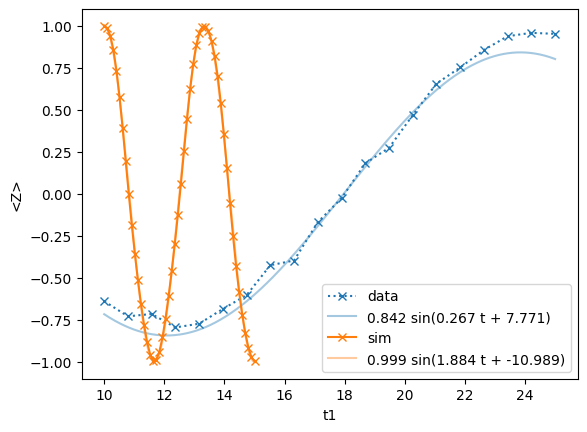

In [7]:
x_lucy_fit, y_lucy_fit, coeffs_fit_lucy = fint_sine(x_lucy, y_lucy, [1., 0.6, 1])

plt.plot(x_lucy, y_lucy, "x:", label="data")
plt.plot(x_lucy_fit, y_lucy_fit, "-", color="tab:blue", label=f"{coeffs_fit_lucy[0]:.3f} sin({coeffs_fit_lucy[1]:.3f} t + {coeffs_fit_lucy[2]:.3f})", alpha=0.4)

params_sim = jnp.array([amp0, phi0])
x_sim = jnp.linspace(10., 15., 50)
y_sim = jax.vmap(qnode_sim, (None, 0))(params_sim, x_sim)
x_fit, y_fit, coeffs_fit_sim = fint_sine(x_sim, y_sim, [2., 1., -np.pi/2])

plt.plot(x_sim, y_sim, "x-", label="sim")
plt.plot(x_fit, y_fit, "-", color="tab:orange", label=f"{coeffs_fit_sim[0]:.3f} sin({coeffs_fit_sim[1]:.3f} t + {coeffs_fit_sim[2]:.3f})", alpha=0.4)
plt.legend()
plt.ylabel("<Z>")
plt.xlabel("t1")

plt.show()

<img src="https://pennylane.ai/_images/calibration0.png" width=500 />

Image: Calibrating the attenuation of the amplitude on the real device. We
see much slower Rabi oscillations compared to simulation because on the
real device, the amplitude that arrives at the qubit is
attenuated.

We see that the oscillation on the real device is significantly slower
due to the attenuation. We can estimate this attenuation by the ratio of
the measured Rabi frequency for the simulation and device execution.


In [8]:
attenuation = np.abs(coeffs_fit_lucy[1] / coeffs_fit_sim[1])
print(attenuation)

0.14168410883816532


We can now plot the same comparison above but with the attenuation
factored in and see a better match between simulation and device
execution.


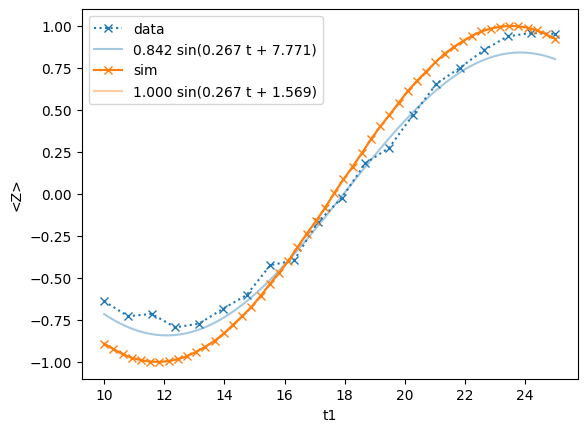

In [9]:
plt.plot(x_lucy, y_lucy, "x:", label="data")
plt.plot(x_lucy_fit, y_lucy_fit, "-", color="tab:blue", label=f"{coeffs_fit_lucy[0]:.3f} sin({coeffs_fit_lucy[1]:.3f} t + {coeffs_fit_lucy[2]:.3f})", alpha=0.4)

# same circuit but in simulation
params_sim = jnp.array([attenuation * amp0, phi0])
x_sim = jnp.linspace(10., 25., 50)
y_sim = jax.vmap(qnode_sim, (None, 0))(params_sim, x_sim)
x_fit, y_fit, coeffs_fit_sim = fint_sine(x_sim, y_sim, [2., 0.5, -np.pi/2])

plt.plot(x_sim, y_sim, "x-", label="sim")
plt.plot(x_fit, y_fit, "-", color="tab:orange", label=f"{coeffs_fit_sim[0]:.3f} sin({coeffs_fit_sim[1]:.3f} t + {coeffs_fit_sim[2]:.3f})", alpha=0.4)
plt.legend()
plt.ylabel("<Z>")
plt.xlabel("t1")

plt.show()

Image: Taking into account the attenuation, we get a much better match
between simulation and hardware
execution.


In particular, we see a match in both Rabi frequencies. The error in
terms of the magnitude of the Rabi oscillation may be due to different
sources. For one, the qubit has a readout fidelity of $93\%$, according
to the vendor. Another possible source is classical and quantum
crosstalk that is not considered in our classical model. Though, we
suspect the main source for error beyond readout fidelity to come from
excitations to higher levels, caused by strong amplitudes and rapid
changes in the signal.


X-Y Rotations
=============

We now want to experiment with performing X- and Y-rotations by setting
the phase. For that, we compute expectation values of
$\langle X \rangle$, $\langle Y \rangle$, and $\langle Z \rangle$ while
changing the phase $\phi$ at a fixed duration of $15 \text{ ns}$ and
output amplitude of $0.3$ (arbitrary unit $\in [0, 1]$).


In [10]:
# For more realistic simulations, we attenuate the (constant) amplitude
def amplitude(p, t):
    return attenuation * p
Hd_attenuated = qml.pulse.transmon_drive(amplitude, qml.pulse.constant, qubit_freq, wires=[wire])

@jax.jit
@qml.qnode(dev_sim, interface="jax")
def qnode_sim(params, duration=15.):
    qml.evolve(H0 + Hd_attenuated)(params, t=duration, atol=1e-12)
    return [qml.expval(qml.PauliX(wire)), qml.expval(qml.PauliY(wire)), qml.expval(qml.PauliZ(wire))]

@qml.qnode(dev_lucy, interface="jax")
def qnode_lucy(params, duration=15.):
    qml.evolve(H0 + Hd0)(params, t=duration)
    return [qml.expval(qml.PauliX(wire)), qml.expval(qml.PauliY(wire)), qml.expval(qml.PauliZ(wire))]


phi0, phi1, n_phis = -np.pi, np.pi, 20
amp0 = 0.3
x_lucy = np.linspace(phi0, phi1, n_phis)
y_lucy = np.array([qnode_lucy([amp0, phi]) for phi in x_lucy])

With the attenuation explicitly taken into account, we can now achieve a
good comparison between simulation and device execution.


(-1.05, 1.05)

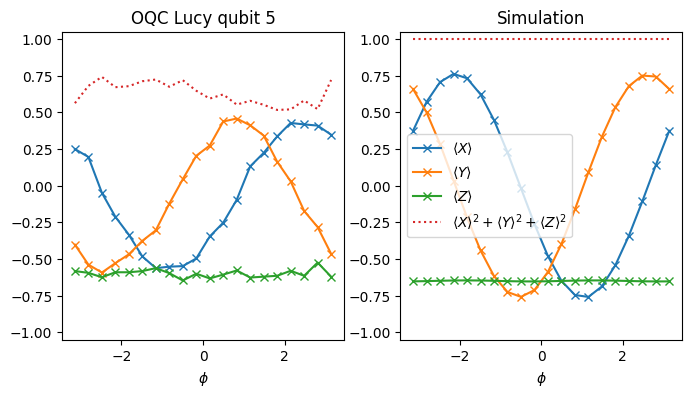

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

ax = axs[0]
ax.plot(x_lucy, y_lucy[:, 0], "x-", label="$\\langle X \\rangle$")
ax.plot(x_lucy, y_lucy[:, 1], "x-", label="$\\langle Y \\rangle$")
ax.plot(x_lucy, y_lucy[:, 2], "x-", label="$\\langle Z \\rangle$")
ax.plot(x_lucy, np.sum(y_lucy**2, axis=1), ":", label="$\\langle X \\rangle^2 + \\langle Y \\rangle^2 + \\langle Z \\rangle^2$")
ax.set_xlabel("$\\phi$")
ax.set_title(f"OQC Lucy qubit {wire}")
ax.set_ylim((-1.05, 1.05))

x_sim = x_lucy
params_sim = jnp.array([[amp0, phi] for phi in x_sim])
y_sim = np.array(jax.vmap(qnode_sim)(params_sim))

ax = axs[1]
ax.plot(x_sim, y_sim[0], "x-", label="$\\langle X \\rangle$")
ax.plot(x_sim, y_sim[1], "x-", label="$\\langle Y \\rangle$")
ax.plot(x_sim, y_sim[2], "x-", label="$\\langle Z \\rangle$")
ax.plot(x_sim, np.sum(y_sim**2, axis=0), ":", label="$\\langle X \\rangle^2 + \\langle Y \\rangle^2 + \\langle Z \\rangle^2$")

ax.set_xlabel("$\\phi$")
ax.set_title("Simulation")
ax.legend()
ax.set_ylim((-1.05, 1.05))

Figure: By changing the phase of our constant drive, we arrive on different
longitudes on the Bloch sphere. The rotation angle, given by the
constant amplitude and pulse duration, is constant as indicated by the Z
component.

As expected, we see a constant $\langle Z \rangle$ contribution, as
changing $\phi$ delays the precession around the Z-axis and we land on a
fixed latitude. What is changed is the longitude, leading to different
rotation axes in the X-Y-plane. The qubit frame interpretation of this
picture is that we simply change the rotation axis by setting different
phases, as discussed in the last paragraph of the transmon physics
section above.

Conclusion
==========

Overall, we have demonstrated the basic working principles of transmon
qubit devices and have shown how one can perform such hardware-level
manipulations on a physical device in PennyLane. Stay tuned for more
content on differentiating pulse circuits natively on hardware in a
future demo on `ODEgen` [3].

References
==========




[1]: J. Rahamim, T. Behrle, M. J. Peterer, A. Patterson, P. Spring, T. Tsunoda, R. Manenti, G. Tancredi, P. J. Leek  
    “Double-sided coaxial  circuit QED with out-of-plane wiring”  
    [arXiv:1703.05828](https://arxiv.org/abs/1703.05828) 2017.  

[2]: Philip Krantz, Morten Kjaergaard, Fei Yan, Terry P. Orlando, Simon Gustavsson, William D. Oliver  
    "A Quantum Engineer’s Guide to Superconducting Qubits"  
    [arXiv:1904.06560](https://arxiv.org/abs/1904.06560), 2019.  

[3]: Korbinian Kottmann, Nathan Killoran  
    "Evaluating analytic gradients of pulse programs on quantum computers"  
    [arXiv:2309.16756](https://arxiv.org/abs/2309.16756), 2023.  

About the author
================

Korbinian is a Quantum Scientist at Xanadu, interested in quantum simulation and quantum software.
